# Correlation Coefficient vs. Coefficient of Efficiency

Originated: Katie Brennan , October 2020

#### What is this notebook about?
When we're trying to reconstruct something, we need metrics to tell us how well our reconstructions match the truth. In the Hakim group we often use both correlation and coefficient of efficiency (CE) as skill metrics. Each of these metrics tell us slightly different things about how good our recosntruction is.  This notebook, aims to give an introduction to what these two metrics are and some intuition about what they mean. 

### The short story:
Corrleation only takes into account the relative timing of signal so magnitude and bias don't affect correlation. When we're trying to reconstruct something, we want to check if we're getting all of these different factors right so we also look at CE. CE takes into account all three things: timing, magnitude and bias. Its a much harder metric than correlation to perform well at so we often look at it next to correlation to get a sense of how much skill we're getting in terms of timing versus magnitude and bias if that makes sense? 

There are certainly other useful metrics one could use (e.g. mean squared error), but in the Hakim group we've taken a liking to CE. Below we'll go through some simple examples to try to get a handle on the differences between correlation versus CE.

### Definitions: 
#### Correlation coeffiecient (R): 
The correlation coefficient (R) measures relative phasing of two time series or spatial patterns are.

\begin{equation}
R = \frac{\sum_{i=1}^{n} {(x_{i}-\bar{x})(v_{i}-\bar{v})}}{\sqrt{\sum_{i}^{n}{(x_{i}-\bar{x})^{2}}}\sqrt{\sum_{i}^{n}{(v_{i}-\bar{v})^{2}}}} %= \frac{cov(x,v)}{\sigma_{x} \sigma_{v}}.
\end{equation}

Here $v$ is the verification data and $x$ is the state being evaluated (the reconstructed value).  The square of correlation coefficient describes the percentage of the variance in $v$ that is explained by $x$.

#### Coefficient of efficiency (CE): 
The coefficient of efficiency (CE, Nash et al. 1970), like the correlation coefficient, measures the phasing of two datasets, but also takes into account bias and amplitude differences between the two quantities. 

 \begin{equation}
 CE = 1 - \frac{\sum_{i}^{n}(v_{i}-x_{i})^{2}}{\sum_{i}^{n}(v_{i}-\bar{v})^{2}}.
 \end{equation}
 
 This quantity has an upper bound of one and is unbounded in the negative direction (aka it can go all the way to negative infinity). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
sys.path.insert(1,'/home/disk/kalman2/mkb22/pyLMR')
from LMR_utils import coefficient_efficiency

In [79]:
def plot_2_timeseries(time, a, b, ce, r, lmin, lmax, a_label, b_label):
    plt.plot(time, a, label=a_label)
    plt.plot(time, b, label=b_label)
    
    plt.xlabel('Time')
    plt.title('Random variables')
    plt.ylim(lmin,lmax)
    
    if lmin>100:
        f = lmax/10 - 5
    else: 
        f=10

    plt.text(0,lmin+2*f,('CE = '+str(np.round(ce,2))), fontsize=14)
    plt.text(0,lmin+f,('R = '+str(np.round(r,2))), fontsize=14)

    plt.legend(loc='lower right')

#### First we'll make a random 'time' series of 100 integers drawn from 0 to 100: 

In [55]:
a = np.random.random_integers(0,100,(100))
time = np.arange(0,100,1)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 100 + 1) instead
  """Entry point for launching an IPython kernel.


First note that when we calculate the CE and correlation of this random variable with itself we get 1.0 for both (yay!). 

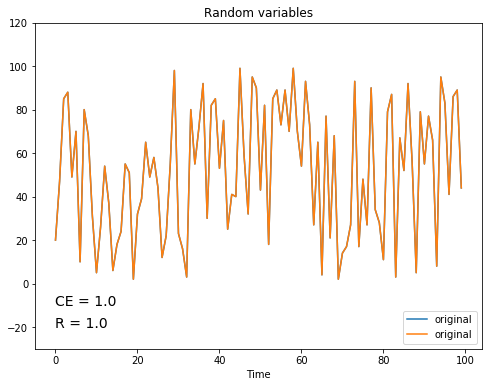

In [80]:
r_aa = np.corrcoef(a,a)[0, 1]
ce_aa = coefficient_efficiency(a,a)

fig = plt.figure(figsize=(8,6))

plot_2_timeseries(time, a, a, ce_aa, r_aa, -30, 120, 'original', 'original')

## 1. Introduce a bias: 

Next we'll introduce a bias of 50 to our original variable. Note the the R value remains the same (1.0) but the CE value is now negative

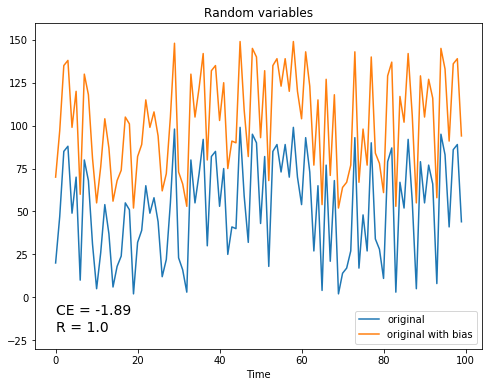

In [81]:
b = a+50

r_ab = np.corrcoef(a,b)[0, 1]
ce_ab = coefficient_efficiency(a,b)

fig = plt.figure(figsize=(8,6))

plot_2_timeseries(time, a, b, ce_ab, r_ab,-30,160, 'original', 'original with bias')

Similarly is we multipy the original random variable by a factor of 2, the correlation doesn't change but the CE value does. 

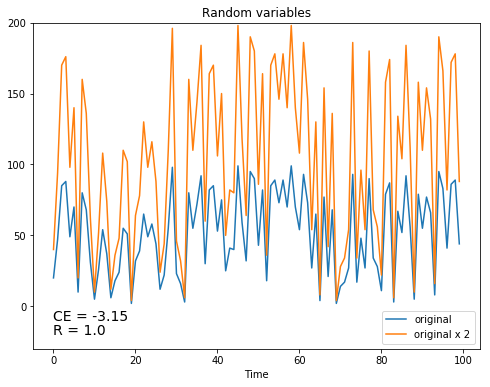

In [82]:
c = a*2

r_ac = np.corrcoef(a,c)[0, 1]
ce_ac = coefficient_efficiency(a,c)

fig = plt.figure(figsize=(8,6))

plot_2_timeseries(time, a, c, ce_ac, r_ac,-30,200, 'original', 'original x 2')

## 2. Alter the magnitude of the signal: 

#### What if we look at anomalies and simply double variance?

By looking at anomalies, we're removing the influence of bias. Note here when we double the variance of anomalies, the CE value is exactly zero, which simply means the ratio of the variance in the verification dataset and the sum of squared error is exactly 1. 

$\frac{\sum_{i}^{n}(v_{i}-x_{i})^{2}}{\sum_{i}^{n}(v_{i}-\bar{v})^{2}} = 1$ 

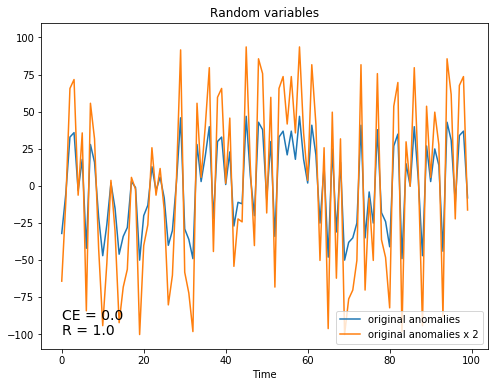

In [84]:
a_anom = a - np.mean(a)
d = a_anom*2

r_ad = np.corrcoef(a_anom,d)[0, 1]
ce_ad = coefficient_efficiency(a_anom,d)

fig = plt.figure(figsize=(8,6))

plot_2_timeseries(time, a_anom, d, ce_ad, r_ad,-110,110, 'original anomalies', 'original anomalies x 2')

If we go even further and muliply anomalies by 10, CE falls well below zero. 

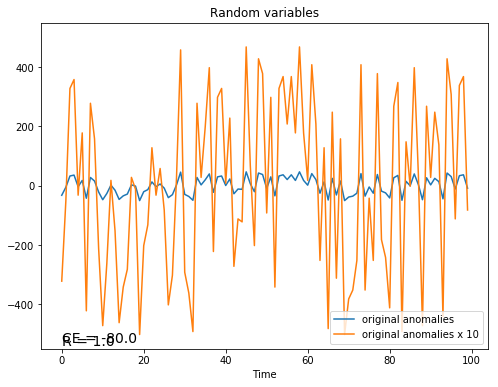

In [86]:
a_anom = a - np.mean(a)
e = a_anom*10

r_ae = np.corrcoef(a_anom,e)[0, 1]
ce_ae = coefficient_efficiency(a_anom,e)

fig = plt.figure(figsize=(8,6))

plot_2_timeseries(time, a_anom, e, ce_ae, r_ae,-550,550, 'original anomalies', 'original anomalies x 10')

## 3. Change the timing of the signal: 

Note when we change the timing of the signal by 1 timestep, this leads to a negative CE and a nearly zero R value

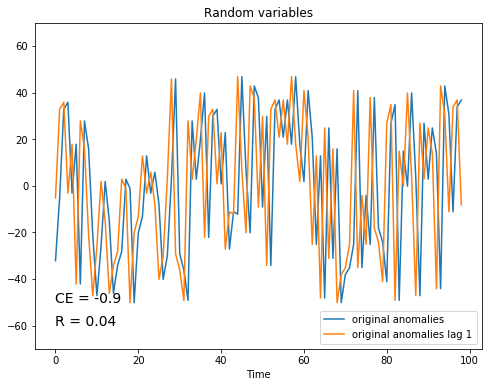

In [88]:
a_anom_lag1 = a_anom[1:]

r_alag1 = np.corrcoef(a_anom[:-1],a_anom_lag1)[0, 1]
ce_alag1 = coefficient_efficiency(a_anom[:-1],a_anom_lag1)

fig = plt.figure(figsize=(8,6))

plot_2_timeseries(time[:-1], a_anom[:-1], a_anom_lag1, ce_alag1, r_alag1,-70,70, 
                  'original anomalies', 'original anomalies lag 1')

## 4. Change the timing of the signal and add bias: 

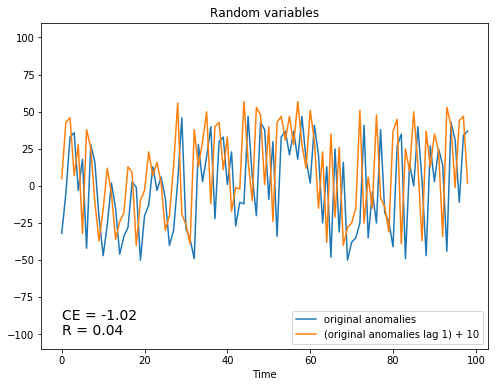

In [93]:
a_anom_lag1 = a_anom[1:]+10

r_alag1 = np.corrcoef(a_anom[:-1],a_anom_lag1)[0, 1]
ce_alag1 = coefficient_efficiency(a_anom[:-1],a_anom_lag1)

fig = plt.figure(figsize=(8,6))

plot_2_timeseries(time[:-1], a_anom[:-1], a_anom_lag1, ce_alag1, r_alag1,-110,110, 
                  'original anomalies', '(original anomalies lag 1) + 10')

## 5. Change the timing and amplitude of the signal: 

Remember from before, when we simply doubled the magnitude of the anomalies we had a CE = 0.0 and R = 1.0. Now, when we do the same but also introduce a lag, the CE becomes negative and R is greatly diminished (R = 0.04 and CE = -3.78). 

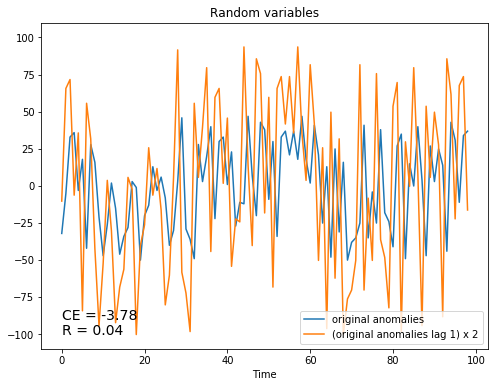

In [100]:
a_anom_lag1 = 2*a_anom[1:]

r_alag1 = np.corrcoef(a_anom[:-1],a_anom_lag1)[0, 1]
ce_alag1 = coefficient_efficiency(a_anom[:-1],a_anom_lag1)

fig = plt.figure(figsize=(8,6))

plot_2_timeseries(time[:-1], a_anom[:-1], a_anom_lag1, ce_alag1, r_alag1,-110,110, 
                  'original anomalies', '(original anomalies lag 1) x 2')

## 6. Now lets add a linear trend: 

First here's a trend with a little bias

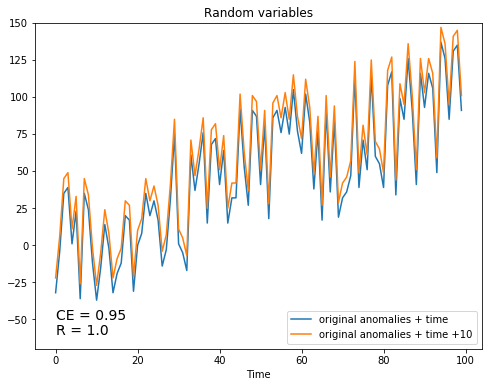

In [108]:
a2 = time+a_anom
a2_comp = a2+10

r_a2 = np.corrcoef(a2,a2_comp)[0, 1]
ce_a2 = coefficient_efficiency(a2,a2_comp)

fig = plt.figure(figsize=(8,6))

plot_2_timeseries(time, a2, a2_comp, ce_a2, r_a2,-70,150, 
                  'original anomalies + time', 'original anomalies + time +10')

Now a trend with a big bias

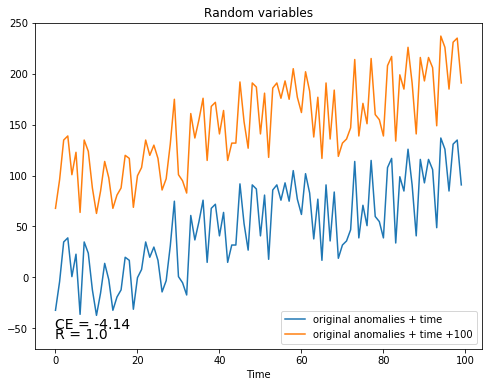

In [114]:
a2 = time+a_anom
a2_comp = a2+100

r_a2 = np.corrcoef(a2,a2_comp)[0, 1]
ce_a2 = coefficient_efficiency(a2,a2_comp)

fig = plt.figure(figsize=(8,6))

plot_2_timeseries(time, a2, a2_comp, ce_a2, r_a2,-70,250, 
                  'original anomalies + time', 'original anomalies + time +100')

Now a we'll just change the timing

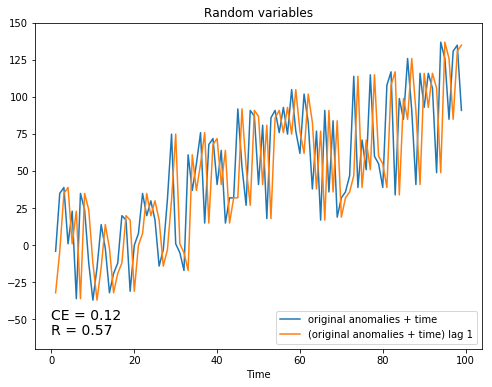

In [121]:
a2 = time+a_anom

r_a2 = np.corrcoef(a2[1:],a2[:-1])[0, 1]
ce_a2 = coefficient_efficiency(a2[1:],a2[:-1])

fig = plt.figure(figsize=(8,6))

plot_2_timeseries(time[1:], a2[1:],a2[:-1], ce_a2, r_a2,-70,150, 
                  'original anomalies + time', '(original anomalies + time) lag 1')

Finally now we'll add a small bias and a lag

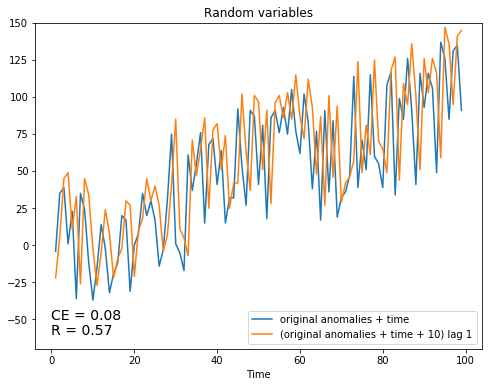

In [122]:
a2 = time+a_anom
a2_comp = a2+10

r_a2 = np.corrcoef(a2[1:],a2_comp[:-1])[0, 1]
ce_a2 = coefficient_efficiency(a2[1:],a2_comp[:-1])

fig = plt.figure(figsize=(8,6))

plot_2_timeseries(time[1:], a2[1:],a2_comp[:-1], ce_a2, r_a2,-70,150, 
                  'original anomalies + time', '(original anomalies + time + 10) lag 1') 